# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.222001,False,-3.485732
1,-0.933105,False,-2.074107
2,-0.813211,True,2.471221
3,-0.915939,False,-0.909618
4,-0.626387,False,-0.782156
...,...,...,...
995,-0.250806,False,-0.670440
996,1.082568,True,9.532965
997,-0.954456,False,-3.438873
998,-0.090437,True,4.728860


<AxesSubplot:xlabel='v0'>

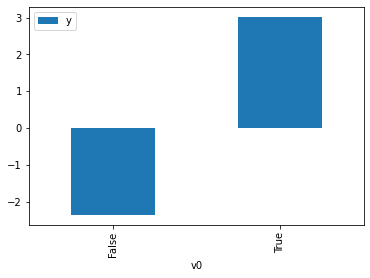

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

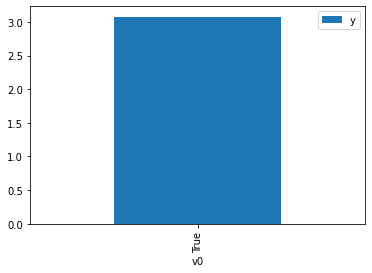

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.182256,False,-3.623080,0.801734,1.247296
1,-0.487649,False,-2.121413,0.658217,1.519255
2,-0.904946,False,-2.846964,0.750450,1.332533
3,-0.859777,False,-3.200673,0.741308,1.348968
4,-0.148540,False,-1.170134,0.572781,1.745868
...,...,...,...,...,...
995,-0.336902,False,1.618981,0.621135,1.609956
996,-0.692316,False,-1.729917,0.705564,1.417306
997,-1.620600,False,-4.566993,0.865914,1.154849
998,-1.892528,False,-3.718492,0.896201,1.115821


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.475718,True,5.599699,0.344655,2.901452
1,-1.275431,True,2.667094,0.182922,5.466818
2,-1.705304,True,0.449158,0.123926,8.069303
3,-1.423017,True,1.696863,0.160530,6.229372
4,-2.539763,True,0.648335,0.054840,18.234739
...,...,...,...,...,...
995,-1.358155,True,2.322111,0.170085,5.879399
996,-0.637219,True,3.662956,0.306806,3.259387
997,-0.127172,True,3.909599,0.432812,2.310470
998,-0.939359,True,3.532489,0.242731,4.119793


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8130.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:34:30   Log-Likelihood:                         -1404.8
No. Observations:                1000   AIC:                                      2814.
Df Residuals:                     998   BIC:                                      2823.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4655      0.023    106.251      0.000       2.420       2.511
x2             5.0233      0.060     84.099      0.000       4.906       5.141
==============================================================================
Omnibus:                        1.574   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.649
Skew:                           0.087   Prob(JB):                        0.439
Kurtosis:                       2.905   Cond. No.                         2.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""